In [1]:
# Использование библиотек
import osmnx as ox # основная библиотека для скачивания графа дорог и дальнейшей работы с ним
import networkx as nx # библиотека для работы с графом, почти не использовали, т.к. больше работали с osmnx
import numpy as np # для работы с матрицами
from random import random # для случайного выбора узлов и случайного назначения весов при заполнении матрицы расстояний
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster # для кластеризации узлов
import json # для записи некоторых данных было удобнее использовать json формат
import csv # для записи информации о полученных кластерах
import matplotlib.pyplot as plt # для визуализации графа, деревьев и кратчайших путей

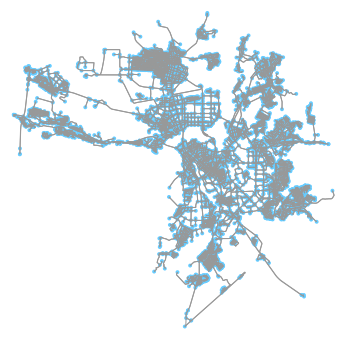

In [88]:
place = {'city' : 'Kazan',
         'country' : 'Russia'}
G = ox.graph_from_place(place, network_type='drive')


fig, ax = ox.plot_graph(G)

fig.savefig('Graph.png')

In [3]:
buildings = ox.footprints.footprints_from_place(place, footprint_type='building', retain_invalid=False, which_result=1)

In [4]:
from random import randint
hospitals = []
apartmentss = []
n = 10000
build = buildings.head(n)['building'].to_dict()

for key,value in build.items():
    if value == 'hospital':
        hospitals.append(key)
    elif value == 'apartments':
        apartmentss.append(key)

# реализация рандомного выбора
# hospital = hospitals[randint(0, len(hospitals)-1)]
N = 100
apartments = []
# for i in range(N):
#     apartments.append(apartmentss[randint(0, len(apartmentss)-1)])

hospital = hospitals[0]
apartments = apartmentss[:N]
    
print("Больница:", hospital)
print("Дома:", apartments)

Больница: 61424274
Дома: [56255883, 56255887, 56255889, 56255891, 56255892, 56255893, 56255896, 56255897, 56255898, 56255899, 56255900, 56255901, 56255906, 56255907, 56255910, 56255911, 56255912, 56255913, 56255914, 56255915, 61424177, 61424184, 61424186, 61424188, 61424193, 61424195, 61424197, 61424199, 61424203, 61424205, 61424206, 61424208, 61424209, 61424210, 61424213, 61424215, 61424229, 61424230, 61424235, 61424238, 61424246, 61424248, 61424250, 61424252, 61424256, 61424262, 61424264, 61424272, 61424280, 61424282, 61424284, 61424288, 61424290, 61424293, 61424300, 61424307, 61424309, 61424311, 61424313, 61424314, 61424315, 61424319, 61424322, 61424327, 61424332, 61424337, 61424338, 61424344, 61424348, 61424349, 61424362, 61424367, 61424373, 61424380, 61424381, 61424387, 61424389, 61424390, 61424392, 61424394, 61424396, 61424406, 61424410, 61424412, 61424416, 61424418, 61424420, 61424423, 61424428, 61424430, 61424432, 61424440, 61424446, 61424447, 61424449, 61424451, 61424453, 6142

In [5]:
# нахождение ближайших узлов для объектов
a = buildings.head(n).to_dict()
hospitals_dict = {}
apartments_dict = {}
hosp_coord = []
aparts_coord = {}

print('Больница') 
bounds = a['geometry'][hospital].bounds
nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
hospitals_dict[hospital] = nearest_node
hosp_coord.append((bounds[1]+bounds[3])/2)
hosp_coord.append((bounds[0]+bounds[2])/2)
print(hospital, nearest_node)
print('------------------')
print('Апартаменты')
for i in apartments:
    bounds = a['geometry'][i].bounds    
    nearest_node = ox.get_nearest_node(G, ((bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2))
    apartments_dict[i] = nearest_node
    aparts_coord[nearest_node] = [(bounds[1]+bounds[3])/2, (bounds[0]+bounds[2])/2]
    print(i, nearest_node)

Больница
61424274 738200564
------------------
Апартаменты
56255883 730355743
56255887 295857558
56255889 484260741
56255891 484260736
56255892 484260739
56255893 534317522
56255896 419830632
56255897 534317522
56255898 419830632
56255899 419830632
56255900 730355768
56255901 295857558
56255906 534317530
56255907 534317530
56255910 3556716975
56255911 484262336
56255912 480690028
56255913 1174838843
56255914 446258388
56255915 1174839583
61424177 1967868583
61424184 847711650
61424186 739162326
61424188 1561540191
61424193 1571092305
61424195 1068922046
61424197 1806029749
61424199 739162327
61424203 1068922016
61424205 423155339
61424206 720459668
61424208 513783875
61424209 1967868578
61424210 972498348
61424213 766889336
61424215 1068922016
61424229 720459668
61424230 720459668
61424235 972498348
61424238 513783875
61424246 423155328
61424248 1068922016
61424250 1843583896
61424252 423155324
61424256 306955246
61424262 2498247367
61424264 847711650
61424272 1465874890
61424280 73916

Скачивание матрицы смежности, заполнение ее расстояниями

In [6]:
a = G.adj
dictionary = {}
i = 0
for key, value in a.items():
    if i == 10:
        break
    for key_a, value_a in value.items():

        if key not in dictionary:
            dictionary[key] = [{key_a:value_a[0]['length']}]
        else:
            dictionary[key].append({key_a:value_a[0]['length']}) 
            
G_pd = nx.to_pandas_adjacency(G)
G_pd = G_pd.values

nodes_list = list(G.nodes())

for i in range(len(G_pd)):
    for j in range(len(G_pd)):
        if G_pd[i][j] == 1:
            for k in range(len(dictionary[nodes_list[i]])):
                if nodes_list[j] in dictionary[nodes_list[i]][k].keys():
                    distance = dictionary[nodes_list[i]][k][nodes_list[j]]   
            weight = 1
            if nodes_list[i] in hospitals_dict.values():
                weight = random() + 1
            G_pd[i][j] = distance * weight
# здесь нужно где 0 заполнить гигантскими расстояниями для дальнейшего нахождения крастчайших путей
        if G_pd[i][j] == 0:
            G_pd[i][j] = 1000000
            
nodes_numbers = {}
for index,i in enumerate(nodes_list):
    nodes_numbers[i]=index 

In [7]:
# для построения дерева кратчайших путей и нахождения длины кратчайших путей используем алгоритм Дейкстры
# N - количество узлов
# S - номер вершины, из которой начинаем путь
# matrix - матрица смежности с расстояниями между узлами (у несмежных узлов расстояние 1000000)
# pred - словарь предков со следующей структурой - {номер узла} : {номер его предка}
def dijkstra(N, S, matrix, pred):
    valid = [True]*N
    weight = [1000000]*N
    weight[S] = 0
    for i in range(N):
        min_weight = 1000001
        ID_min_weight = -1
        for j in range(N):
            if valid[j] and weight[j] < min_weight:
                min_weight = weight[j]
                ID_min_weight = j
                for z in range(N):
                    if weight[ID_min_weight] + matrix[ID_min_weight][z] < weight[z]:
                        weight[z] = weight[ID_min_weight] + matrix[ID_min_weight][z]
                        pred[z] = ID_min_weight
        valid[ID_min_weight] = False
    return weight

In [8]:
hospital_value = list(hospitals_dict.values())[0]
apartments_values = list(apartments_dict.values())

In [9]:
# nodes_numbers

In [10]:
p = {}
d = dijkstra(len(G_pd), nodes_numbers[hospital_value], G_pd, p)
# print(d)

### Сумма кратчайших расстояний от объекта до всех заданных узлов

In [11]:
def find_short_path(pred_dict, index_a, index_b):
    path = []
    if index_a != index_b:
        path.append(index_b)
        temp = index_b
        while pred_dict[temp] != index_a:
            path.append(pred_dict[temp])
            temp = pred_dict[temp]
        path.append(index_a)
        path.reverse()
    return path

In [12]:
nodes_numbers[hospital_value]

1329

In [13]:
short_paths = {}
short_paths_len = 0
for i in apartments_values:
    path = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[i])
    short_paths[nodes_numbers[i]] = path
    short_paths_len += d[nodes_numbers[i]]

In [15]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return -1

#### Дерево кратчайших путей (изображение на графе)

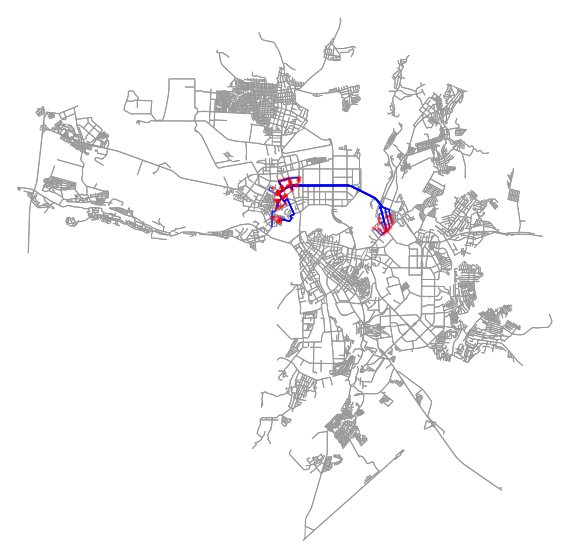

In [108]:
draw_paths = []
# добавляем наши кратчайшие пути в список
for i in short_paths.values():
    draw_paths.append(i)

# так как используем не id узлов, а их номера, то для каждого списка узлов ищем их id в nodes_id
routes = []
for i in draw_paths:
    route = []
    route_colors = []
    node_colors = []
    for j in i:
        key = get_key(nodes_numbers, j)
        # получаем машрут, т.е. список смежных узлов, которые собираемся посещать
        route.append(key) 
    if route != []:
        # если маршрут не пустой, добавляем в список маршрутов
        routes.append(route)

fig, ax = ox.plot_graph_routes(G, routes, route_color='b', node_size = 0, fig_height = 10, fig_width = 10, orig_dest_node_color  = 'r', orig_dest_node_size = 20, route_linewidth = 1.5, save = True, file_format='png', filename='short_path_tree_task2')
plt.show() 

In [18]:
# искомая сумма
short_paths_len

294042.16263853194

### Общая длина дерева от объекта до всех заданных узлов

In [19]:
def tree_weight(tree, matrix, aparts):
    weight = 0
    for i in aparts:
        if i in tree.keys():
            j = tree[i]
            weight += matrix[j][i]
    return weight

In [20]:
aparts = []
for i in apartments_values:
    aparts.append(nodes_numbers[i])
short_path_tree_weight = tree_weight(p, G_pd, aparts)

In [21]:
# искомая длина
short_path_tree_weight

17227.793985063217

### Ищем матрицу кратчайших расстояний между узлами

In [22]:
new_nodes = apartments_values

In [23]:
short_path_matrix = np.zeros((len(new_nodes), len(new_nodes)))

In [24]:
# словарь, который хранит дерево кратчайших расстояний из вершины i
pred_aparts = {}

index_nodes = [] # индексы узлов домов и квартир! и только их!
for i in new_nodes:
    index_nodes.append(nodes_numbers[i]) # в качестве индекса номер, соответствующий id узл

In [26]:
for i in range(len(new_nodes)):
    pred = {}
    index = index_nodes[i]
    distance = dijkstra(len(G_pd), index, G_pd, pred)
    pred_aparts[index] = pred
    for j in range(len(new_nodes)):
        short_path_matrix[i][j] = distance[index_nodes[j]]
        
# print(short_path_matrix) 

In [27]:
print(short_path_matrix) 

[[    0.           499.162       1031.257      ...  8994.769
  10321.502       9706.793     ]
 [  499.162          0.           532.095      ...  8495.607
   9822.34        9207.631     ]
 [  797.45         298.288          0.         ...  8765.257
   9746.252       9477.281     ]
 ...
 [ 7349.758       7216.269       7748.364      ...     0.
   1384.575       1388.691     ]
 [ 8722.507       8589.018       9121.113      ...  1919.732
      0.          1739.41      ]
 [ 8410.22799253  8276.73899253  8808.83399253 ...  1463.31799253
   1184.25586763     0.        ]]


In [28]:
# Записываем матрицу кратчайших расстояний в csv файл

def csv_writer(data, path):
    """
    Write data to a CSV file path
    """
    with open(path, "w", newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in data:
            writer.writerow(line)

data = short_path_matrix
path = "matrix_task2.csv"
csv_writer(data, path)

## Кластеризация

In [29]:
# создаем верхнетреугольную матрицу для построения кластеров по следующему принципу:
# смотрим расстояния на симметричных местах и добавляем минимальное
# наша верхнетреугольная матрица выглядит как список
matrix_cluster = []
for i in range(len(short_path_matrix)):
    for j in range(i + 1, len(short_path_matrix)):
        if short_path_matrix[i][j] < short_path_matrix[j][i]:
            matrix_cluster.append(short_path_matrix[i][j])
        else:
            matrix_cluster.append(short_path_matrix[j][i])
            
# print(matrix_cluster)       

## Задание 2 
#### Пункт 2
Разбить выбранные узлы на кластеры, используя метод полной связи (сomplete-linkage clustering).

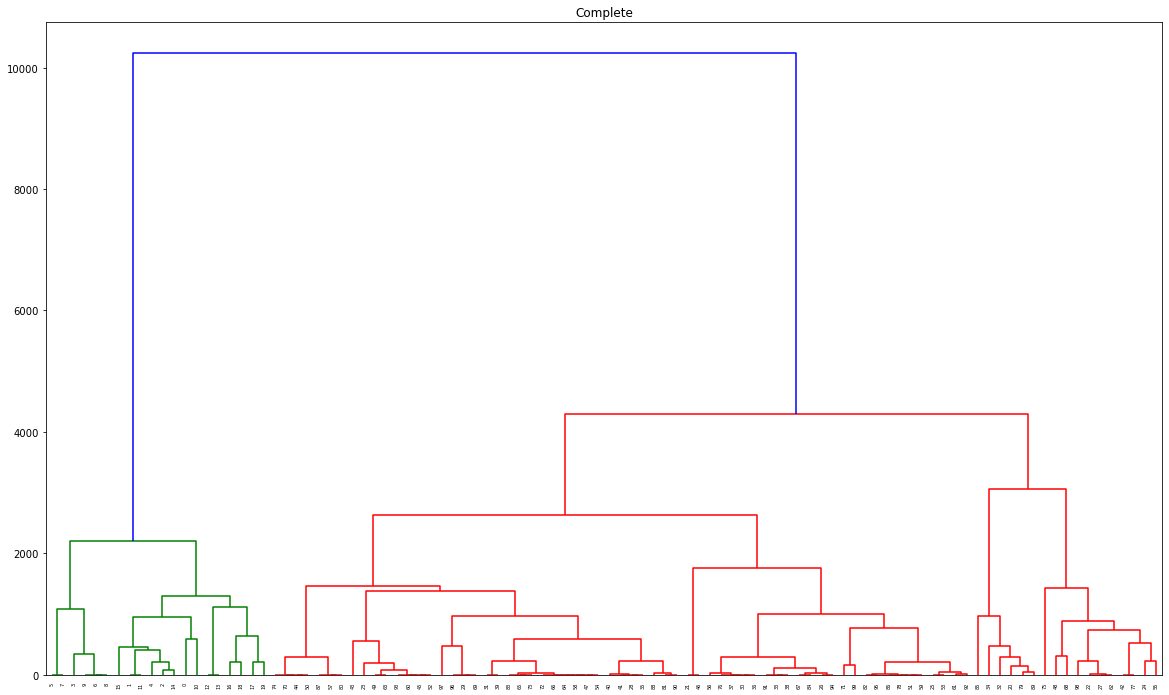

In [100]:
# для этого используем встроенные функции библиотеки scipy.cluster.hierarchy
Z = linkage(matrix_cluster, 'complete') # кластеризация методов полной связи
plt.rcParams["figure.figsize"] = (20, 12)
plt.title('Complete')
dendrogram(Z) # построение дендрограммы разбиения узлов
plt.show()

#### Пункт 3
Разбиваем узлы на k кластеров.
k=2, 3, 5

In [32]:
# разбиваем на 2 кластера
num_clust = 2
Z2 = fcluster(Z, num_clust, 'maxclust')
Z2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [33]:
# разбиваем на 3 кластера
num_clust = 3
Z3 = fcluster(Z, num_clust, 'maxclust')
Z3

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2,
       3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2], dtype=int32)

In [34]:
# разбиваем на 5 кластеров
num_clust = 5
Z5 = fcluster(Z, num_clust, 'maxclust')
Z5

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3,
       5, 2, 5, 3, 3, 5, 2, 2, 3, 2, 4, 3, 4, 2, 3, 3, 3, 2, 2, 2, 5, 2,
       2, 2, 3, 2, 5, 2, 2, 3, 2, 3, 2, 5, 3, 2, 2, 3, 2, 3, 5, 2, 2, 2,
       2, 3, 5, 2, 2, 3, 2, 2, 2, 5, 3, 5, 3, 4, 2, 2, 3, 2, 3, 4, 3, 2,
       2, 4, 2, 3, 3, 2, 3, 3, 2, 2, 5, 3], dtype=int32)

In [75]:
# записываем информацию о разбиении на кластеры в csv файл
Z_list = []

Z_list.append(Z2)
Z_list.append(Z3)
Z_list.append(Z5)
data = Z_list
path = "clusters.csv"
csv_writer(data, path)

### Ищем центроиды и деревья кратчайших расстояний для кластеров c k = 2

##### а) Найдем координаты центроидов для каждого кластера и ближайшие к ним узлы

In [37]:
c1 = [0, 0]
c2 = [0, 0]
k1 = 0
k2 = 0

# складываем соответствующие географические координаты узлов в соответствуюшие списки
for i in range(len(Z2)):
    key = get_key(nodes_numbers, index_nodes[i])
    coords = aparts_coord[key]
    if Z2[i] == 1:
        c1[0] += coords[0]
        c1[1] += coords[1]
        # и считаем количество узлов в кластере для нахождения средних координат
        k1 += 1
    else:
        c2[0] += coords[0]
        c2[1] += coords[1]
        k2 += 1
# находим среднее значение координат узлов, т. е., координаты наших центроидов
for i in range(len(c1)):
    c1[i] /= k1
for j in range(len(c2)):
    c2[j] /= k2
print("Coordinates: ", c1, c2)
# ищем ближайшие узлы для наших центроидов
center1 = ox.get_nearest_node(G, (c1[0], c1[1]))
center2 = ox.get_nearest_node(G, (c2[0], c2[1]))

print("Nodes: ", center1, center2)

Coordinates:  [55.805068625000004, 49.182774722499985] [55.823779774375, 49.088019895]
Nodes:  730355762 1402061286


#####  b) Найдем кратчайшие пути от объекта до центроидов и сумму этих кратчайших расстояний

In [38]:
# Находим кратчайшие пути от объекта до центроидов
path1 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center1])
path2 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center2])

In [39]:
# считаем сумму этих путей
len_path1 = d[nodes_numbers[center1]]
len_path2 = d[nodes_numbers[center2]]
len_paths = len_path1 + len_path2
len_paths

8852.808985063208

In [40]:
def draw_short_path(graph, path, height, width):
    route = []
    for i in path:
        key = get_key(nodes_numbers, i)
        route.append(key)      
    ox.plot_graph_route(graph, route, node_size = 0, fig_height=height, fig_width=width)

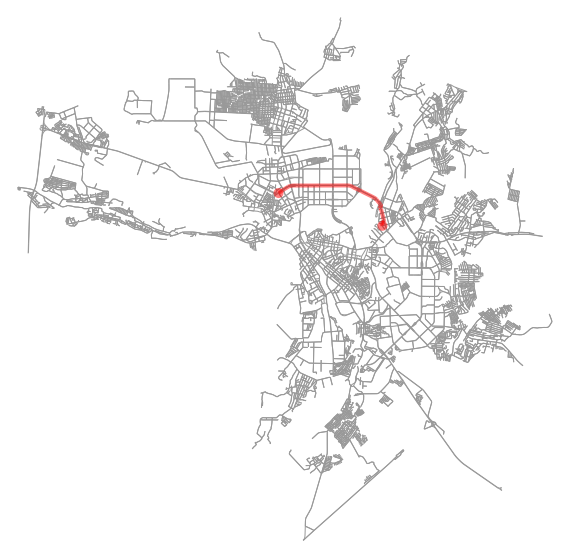

In [41]:
# Нарисуем кратчайший путь от объекта до первого центроида
draw_short_path(G, path1, 10, 10)

#####  b) Построим дерево кратчайших путей от объекта до центроидов и вычислим его длину

In [42]:
centers = []
centers.append(nodes_numbers[center1])
centers.append(nodes_numbers[center2])
short_path_tree_centers = tree_weight(p, G_pd, centers)

In [43]:
# длина дерева кратчайших путей из объекта до центроидов
short_path_tree_centers

197.09900000000002

#####  c) Считаем кратчайшие пути от каждого центроида до остальных узлов кластера

In [121]:
p1 = {}
p2 = {}
# для этого запускаем Дейкстру из центроидов
d1 = dijkstra(len(G_pd), nodes_numbers[center1], G_pd, p1)
d2 = dijkstra(len(G_pd), nodes_numbers[center2], G_pd, p2)

In [122]:
nodes_c1 = []
nodes_c2 = []

short_paths_c1 = {}
short_paths_c2 = {}
short_paths_len_c1 = 0
short_paths_len_c2 = 0
for i in range(len(Z2)):
    if Z2[i] == 1:
        nodes_c1.append(i)
        path_c1 = find_short_path(p1, nodes_numbers[center1], nodes_numbers[apartments_values[i]])
        short_paths_c1[nodes_numbers[apartments_values[i]]] = path_c1
        short_paths_len_c1 += d1[nodes_numbers[apartments_values[i]]]
    else:
        nodes_c2.append(i)
        path_c2 = find_short_path(p2, nodes_numbers[center2], nodes_numbers[apartments_values[i]])
        short_paths_c2[nodes_numbers[apartments_values[i]]] = path_c2
        short_paths_len_c2 += d2[nodes_numbers[apartments_values[i]]]
        

#### Визуализация разбиения узлов на кластеры

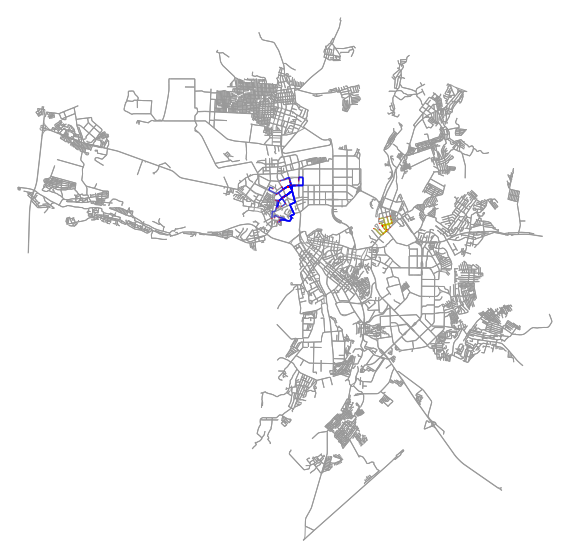

In [123]:
draw_paths= []
length = []
l = 0

for i in short_paths_c1.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)
l = 0
for i in short_paths_c2.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)


# так как используем не id узлов, а их номера, то для каждого списка узлов ищем их id в nodes_id
routes = []
for i in draw_paths:
    route = []
    route_colors = []
    node_colors = []
    for j in i:
        key = get_key(nodes_numbers, j)
        # получаем машрут, т.е. список смежных узлов, которые собираемся посещать
        route.append(key) 
    if route != []:
        # если маршрут не пустой, добавляем в список маршрутов
        routes.append(route)

route_colors = ['y']*length[0] + ['b']*length[1]
fig, ax = ox.plot_graph_routes(G, routes, route_color=route_colors, node_size = 0, fig_height = 10, fig_width = 10, orig_dest_node_color  = 'r', orig_dest_node_size = 1, orig_dest_node_alpha = 1, route_linewidth = 1.5, save = True, file_format='png', filename='short_path_tree_cluster2')
plt.show()

Сумма кратчайших путей от первого центроида до остальных узлов кластера

In [46]:
short_paths_len_c1

15957.311999999998

Сумма кратчайших путей от второго центроида до остальных узлов кластера

In [47]:
short_paths_len_c2

96172.68200000004

#####  Посчитаем длину деревьев кратчайших расстояний из центроидов

In [48]:
nodes = []
for i in nodes_c1:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c1 = tree_weight(p1, G_pd, nodes)

# Длина дерева из первого центроида
short_path_tree_weight_c1

4714.677000000001

In [49]:
nodes = []
for i in nodes_c2:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c2 = tree_weight(p2, G_pd, nodes)

# Длина дерева из второго центроида
short_path_tree_weight_c2

12467.330999999998

##### d) Длина дерева кратчайших путей от объекта до узлов кластеров

In [50]:
tree_sum1 = short_path_tree_centers + short_path_tree_weight_c1 + short_path_tree_weight_c2
tree_sum1

17379.107

##### d) Сумма кратчайших путей от объекта до узлов кластеров

In [51]:
paths_sum1 = short_paths_len_c1 + short_paths_len_c2 + len_paths
paths_sum1

120982.80298506324

#### Аналогичные действия выполняем для k = 3 и k = 5

### Ищем центроиды и деревья кратчайших расстояний кластеров c k = 3

In [115]:
c1 = [0, 0]
c2 = [0, 0]
c3 = [0, 0]
k1 = 0
k2 = 0
k3 = 0

# складываем соответствующие географические координаты узлов в соответствуюшие списки
for i in range(len(Z3)):
    key = get_key(nodes_numbers, index_nodes[i])
    coords = aparts_coord[key]
    if Z3[i] == 1:
        c1[0] += coords[0]
        c1[1] += coords[1]
        # и считаем количество узлов в кластере для нахождения средниъ координат
        k1 += 1
    elif Z3[i] == 2:
        c2[0] += coords[0]
        c2[1] += coords[1]
        k2 += 1
    else:
        c3[0] += coords[0]
        c3[1] += coords[1]
        k3 += 1

# находим среднее значение координат узлов, т. е., координаты наших центроидов
for i in range(len(c1)):
    c1[i] /= k1
for j in range(len(c2)):
    c2[j] /= k2
for k in range(len(c3)):
    c3[k] /= k3
print("Coordinates: ", c1, c2, c3)
# ищем ближайшие узлы для наших центроидов
center1 = ox.get_nearest_node(G, (c1[0], c1[1]))
center2 = ox.get_nearest_node(G, (c2[0], c2[1]))
center3 = ox.get_nearest_node(G, (c3[0], c3[1]))

print("Nodes: ", center1, center2, center3)

Coordinates:  [55.805068625000004, 49.182774722499985] [55.82646035873015, 49.08975264047618] [55.81384584411764, 49.08159854411764]
Nodes:  730355762 1068922086 1933319308


In [116]:
# Находим кратчайшие пути от объекта до центроидов
path1 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center1])
path2 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center2])
path3 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center3])

# считаем сумму этих путей
len_path1 = d[nodes_numbers[center1]]
len_path2 = d[nodes_numbers[center2]]
len_path3 = d[nodes_numbers[center3]]
len_paths = len_path1 + len_path2 + len_path3
len_paths

10622.739852694916

In [117]:
centers = []
centers.append(nodes_numbers[center1])
centers.append(nodes_numbers[center2])
centers.append(nodes_numbers[center3])
short_path_tree_centers = tree_weight(p, G_pd, centers)

# длина дерева кратчайшиъ путей из объекта до центроидов
short_path_tree_centers

627.099

In [118]:
p1 = {}
p2 = {}
p3 = {}
d1 = dijkstra(len(G_pd), nodes_numbers[center1], G_pd, p1)
d2 = dijkstra(len(G_pd), nodes_numbers[center2], G_pd, p2)
d3 = dijkstra(len(G_pd), nodes_numbers[center2], G_pd, p3)

In [119]:
nodes_c1 = []
nodes_c2 = []
nodes_c3 = []

short_paths_c1 = {}
short_paths_c2 = {}
short_paths_c3 = {}
short_paths_len_c1 = 0
short_paths_len_c2 = 0
short_paths_len_c3 = 0
for i in range(len(Z3)):
    if Z3[i] == 1:
        nodes_c1.append(i)
        path_c1 = find_short_path(p1, nodes_numbers[center1], nodes_numbers[apartments_values[i]])
        short_paths_c1[nodes_numbers[apartments_values[i]]] = path_c1
        short_paths_len_c1 += d1[nodes_numbers[apartments_values[i]]]
    elif Z3[i] == 2:
        nodes_c2.append(i)
        path_c2 = find_short_path(p2, nodes_numbers[center2], nodes_numbers[apartments_values[i]])
        short_paths_c2[nodes_numbers[apartments_values[i]]] = path_c2
        short_paths_len_c2 += d2[nodes_numbers[apartments_values[i]]]
    else:
        nodes_c3.append(i)
        path_c3 = find_short_path(p3, nodes_numbers[center2], nodes_numbers[apartments_values[i]])
        short_paths_c3[nodes_numbers[apartments_values[i]]] = path_c3
        short_paths_len_c3 += d3[nodes_numbers[apartments_values[i]]]

#### Визуализация разбиения на кластеры

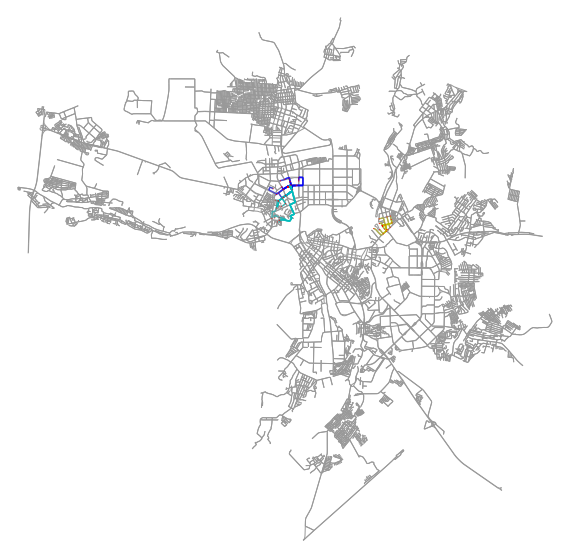

In [120]:
draw_paths= []
length = []
l = 0

for i in short_paths_c1.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)
l = 0
for i in short_paths_c2.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)
l = 0
for i in short_paths_c3.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)

# так как используем не id узлов, а их номера, то для каждого списка узлов ищем их id в nodes_id
routes = []
for i in draw_paths:
    route = []
    route_colors = []
    node_colors = []
    for j in i:
        key = get_key(nodes_numbers, j)
        # получаем машрут, т.е. список смежных узлов, которые собираемся посещать
        route.append(key) 
    if route != []:
        # если маршрут не пустой, добавляем в список маршрутов
        routes.append(route)

route_colors = ['y']*length[0] + ['b']*length[1] + ['c']*length[2]
fig, ax = ox.plot_graph_routes(G, routes, route_color=route_colors, node_size = 0, fig_height = 10, fig_width = 10, orig_dest_node_color  = 'r', orig_dest_node_size = 1, orig_dest_node_alpha = 1, route_linewidth = 1.5, save = True, file_format='png', filename='short_path_tree_cluster3')
plt.show()

In [57]:
short_paths_len_c1

15957.311999999998

In [58]:
short_paths_len_c2

81920.00699999998

In [59]:
short_paths_len_c3

43361.626

In [60]:
nodes = []
for i in nodes_c1:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c1 = tree_weight(p1, G_pd, nodes)

# Длина дерева из первого центроида
print(short_path_tree_weight_c1)

nodes = []
for i in nodes_c2:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c2 = tree_weight(p2, G_pd, nodes)

# Длина дерева из второго центроида
print(short_path_tree_weight_c2, nodes)

nodes = []
for i in nodes_c3:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c3 = tree_weight(p3, G_pd, nodes)

# Длина дерева из третьего центроида
print(short_path_tree_weight_c3)

4714.677000000001
7042.044000000003 [1473, 5842, 5688, 2053, 5680, 2353, 2444, 6037, 4076, 5680, 2444, 2444, 4076, 6037, 2346, 5680, 2344, 320, 6275, 1473, 6203, 6272, 320, 4441, 6275, 5688, 6203, 2446, 2074, 6203, 4441, 6275, 5703, 6272, 6203, 6198, 6203, 3153, 2353, 320, 1329, 6203, 6198, 320, 2444, 4441, 2074, 2355, 3200, 6198, 3153, 4441, 2074, 2354, 2355, 4076, 5694, 6275, 2053, 3200, 2353, 1308, 2528]
2833.6839999999997


In [61]:
tree_sum2 = short_path_tree_centers + short_path_tree_weight_c1 + short_path_tree_weight_c2 + short_path_tree_weight_c3
tree_sum2

15217.504000000003

In [62]:
paths_sum2 = short_paths_len_c1 + short_paths_len_c2 + short_paths_len_c3 + len_paths
paths_sum2

151861.6848526949

### Ищем центроиды и деревья кратчайших расстояний для кластеров с k = 5

In [63]:
c1 = [0, 0]
c2 = [0, 0]
c3 = [0, 0]
c4 = [0, 0]
c5 = [0, 0]
k1 = 0
k2 = 0
k3 = 0
k4 = 0
k5 = 0

# складываем соответствующие географические координаты узлов в соответствуюшие списки
for i in range(len(Z5)):
    key = get_key(nodes_numbers, index_nodes[i])
    coords = aparts_coord[key]
    if Z5[i] == 1:
        c1[0] += coords[0]
        c1[1] += coords[1]
        # и считаем количество узлов в кластере для нахождения средних координат
        k1 += 1
    elif Z5[i] == 2:
        c2[0] += coords[0]
        c2[1] += coords[1]
        k2 += 1
    elif Z5[i] == 3:
        c3[0] += coords[0]
        c3[1] += coords[1]
        k3 += 1
    elif Z5[i] == 4:
        c4[0] += coords[0]
        c4[1] += coords[1]
        k4 += 1
    else:
        c5[0] += coords[0]
        c5[1] += coords[1]
        k5 += 1

# находим среднее значение координат узлов, т. е., координаты наших центроидов
for i in range(len(c1)):
    c1[i] /= k1
for j in range(len(c2)):
    c2[j] /= k2
for k in range(len(c3)):
    c3[k] /= k3
for l in range(len(c4)):
    c4[l] /= k4
for m in range(len(c5)):
    c5[m] /= k5
print("Coordinates: ", c1, c2, c3, c4, c5)
# ищем ближайшие узлы для наших центроидов
center1 = ox.get_nearest_node(G, (c1[0], c1[1]))
center2 = ox.get_nearest_node(G, (c2[0], c2[1]))
center3 = ox.get_nearest_node(G, (c3[0], c3[1]))
center4 = ox.get_nearest_node(G, (c4[0], c4[1]))
center5 = ox.get_nearest_node(G, (c5[0], c5[1]))

print("Nodes: ", center1, center2, center3, center4, center5)

Coordinates:  [55.805068625000004, 49.182774722499985] [55.828833632432435, 49.09333542837837] [55.82308300769232, 49.08465405769231] [55.808618216666666, 49.081544783333335] [55.81669727727273, 49.08162786818182]
Nodes:  730355762 1465874880 738200564 952084773 739162311


In [64]:
# Находим кратчайшие пути от объекта до центроидов
path1 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center1])
path2 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center2])
path3 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center3])
path4 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center4])
path5 = find_short_path(p, nodes_numbers[hospital_value], nodes_numbers[center5])

# считаем сумму этих путей
len_path1 = d[nodes_numbers[center1]]
len_path2 = d[nodes_numbers[center2]]
len_path3 = d[nodes_numbers[center3]]
len_path4 = d[nodes_numbers[center4]]
len_path5 = d[nodes_numbers[center5]]
len_paths = len_path1 + len_path2 + len_path3 + len_path4 + len_path5
len_paths

14526.313720326627

In [65]:
centers = []
centers.append(nodes_numbers[center1])
centers.append(nodes_numbers[center2])
centers.append(nodes_numbers[center3])
centers.append(nodes_numbers[center4])
centers.append(nodes_numbers[center5])
short_path_tree_centers = tree_weight(p, G_pd, centers)

# длина дерева кратчайшиъ путей из объекта до центроидов
short_path_tree_centers

700.896

In [66]:
p1 = {}
p2 = {}
p3 = {}
p4 = {}
p5 = {}
d1 = dijkstra(len(G_pd), nodes_numbers[center1], G_pd, p1)
d2 = dijkstra(len(G_pd), nodes_numbers[center2], G_pd, p2)
d3 = dijkstra(len(G_pd), nodes_numbers[center3], G_pd, p3)
d4 = dijkstra(len(G_pd), nodes_numbers[center4], G_pd, p4)
d5 = dijkstra(len(G_pd), nodes_numbers[center5], G_pd, p5)

In [67]:
nodes_c1 = []
nodes_c2 = []
nodes_c3 = []
nodes_c4 = []
nodes_c5 = []

short_paths_c1 = {}
short_paths_c2 = {}
short_paths_c3 = {}
short_paths_c4 = {}
short_paths_c5 = {}

short_paths_len_c1 = 0
short_paths_len_c2 = 0
short_paths_len_c3 = 0
short_paths_len_c4 = 0
short_paths_len_c5 = 0

for i in range(len(Z5)):
    if Z5[i] == 1:
        nodes_c1.append(i)
        path_c1 = find_short_path(p1, nodes_numbers[center1], nodes_numbers[apartments_values[i]])
        short_paths_c1[nodes_numbers[apartments_values[i]]] = path_c1
        short_paths_len_c1 += d1[nodes_numbers[apartments_values[i]]]
    elif Z5[i] == 2:
        nodes_c2.append(i)
        path_c2 = find_short_path(p2, nodes_numbers[center2], nodes_numbers[apartments_values[i]])
        short_paths_c2[nodes_numbers[apartments_values[i]]] = path_c2
        short_paths_len_c2 += d2[nodes_numbers[apartments_values[i]]]
    elif Z5[i] == 3:
        nodes_c3.append(i)
        path_c3 = find_short_path(p3, nodes_numbers[center3], nodes_numbers[apartments_values[i]])
        short_paths_c3[nodes_numbers[apartments_values[i]]] = path_c3
        short_paths_len_c3 += d3[nodes_numbers[apartments_values[i]]]
    elif Z5[i] == 4:
        nodes_c4.append(i)
        path_c4 = find_short_path(p4, nodes_numbers[center4], nodes_numbers[apartments_values[i]])
        short_paths_c4[nodes_numbers[apartments_values[i]]] = path_c4
        short_paths_len_c4 += d4[nodes_numbers[apartments_values[i]]]
    else:
        nodes_c5.append(i)
        path_c5 = find_short_path(p5, nodes_numbers[center5], nodes_numbers[apartments_values[i]])
        short_paths_c5[nodes_numbers[apartments_values[i]]] = path_c5
        short_paths_len_c5 += d5[nodes_numbers[apartments_values[i]]]

#### Визуализация разбиения на 5 кластеров (более детально видно на сохраненном изображении)

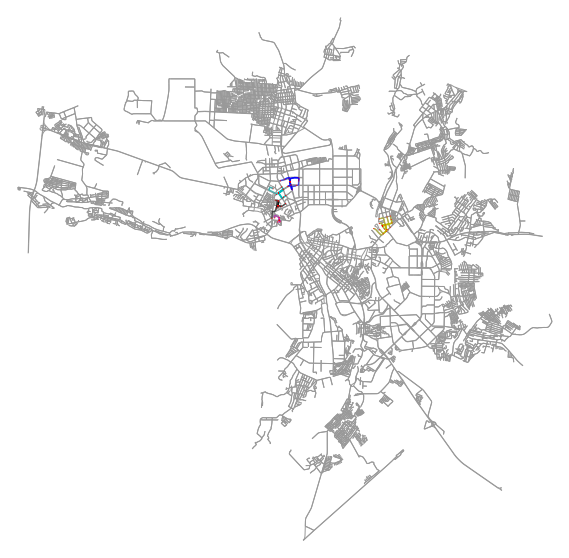

In [114]:
draw_paths= []
length = []
l = 0

for i in short_paths_c1.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)
l = 0
for i in short_paths_c2.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)
l = 0
for i in short_paths_c3.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)
l = 0
for i in short_paths_c4.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)
l = 0
for i in short_paths_c5.values():
    draw_paths.append(i)
    if len(i) != 0:
        l += len(i) - 1
length.append(l)

# так как используем не id узлов, а их номера, то для каждого списка узлов ищем их id в nodes_id
routes = []
for i in draw_paths:
    route = []
    route_colors = []
    node_colors = []
    for j in i:
        key = get_key(nodes_numbers, j)
        # получаем машрут, т.е. список смежных узлов, которые собираемся посещать
        route.append(key) 
    if route != []:
        # если маршрут не пустой, добавляем в список маршрутов
        routes.append(route)

route_colors = ['y']*length[0] + ['b']*length[1] + ['c']*length[2] + ['m']*length[3] + ['k']*length[4]
fig, ax = ox.plot_graph_routes(G, routes, route_color=route_colors, node_size = 0, fig_height = 10, fig_width = 10, orig_dest_node_color  = 'r', orig_dest_node_size = 1, orig_dest_node_alpha = 1, route_linewidth = 1.5, save = True, file_format='png', filename='short_path_tree_cluster5')
plt.show()

In [68]:
print(short_paths_len_c1, short_paths_len_c2, short_paths_len_c3, short_paths_len_c4, short_paths_len_c5)

15957.311999999998 19795.88 20523.672314491363 1317.642 4339.706999999999


In [69]:
nodes = []
for i in nodes_c1:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c1 = tree_weight(p1, G_pd, nodes)

# Длина дерева из первого центроида
print(short_path_tree_weight_c1)

nodes = []
for i in nodes_c2:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c2 = tree_weight(p2, G_pd, nodes)

# Длина дерева из второго центроида
print(short_path_tree_weight_c2)

nodes = []
for i in nodes_c3:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c3 = tree_weight(p3, G_pd, nodes)

# Длина дерева из третьего центроида
print(short_path_tree_weight_c3)

nodes = []
for i in nodes_c4:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c4 = tree_weight(p4, G_pd, nodes)

# Длина дерева из третьего центроида
print(short_path_tree_weight_c4)

nodes = []
for i in nodes_c5:
    nodes.append(nodes_numbers[apartments_values[i]])
short_path_tree_weight_c5 = tree_weight(p5, G_pd, nodes)

# Длина дерева из третьего центроида
print(short_path_tree_weight_c5)

4714.677000000001
4497.210999999999
2554.0279850632087
579.4
2501.3109999999997


In [70]:
tree_sum3 = short_path_tree_centers + short_path_tree_weight_c1 + short_path_tree_weight_c2 + short_path_tree_weight_c3 + short_path_tree_weight_c4 + short_path_tree_weight_c5
tree_sum3

15547.522985063208

In [71]:
paths_sum3 = short_paths_len_c1 + short_paths_len_c2 + short_paths_len_c3 + short_paths_len_c4 + short_paths_len_c5 + len_paths
paths_sum3

76460.52703481799

### Сравнение результатов

In [72]:
print("Длина дерева кратчайших путей")
print("Без кластеризации: ", short_path_tree_weight)
print("2 кластера: ", tree_sum1)
print("3 кластера: ", tree_sum2)
print("5 кластеров: ", tree_sum3)

Длина дерева кратчайших путей
Без кластеризации:  17227.793985063217
2 кластера:  17379.107
3 кластера:  15217.504000000003
5 кластеров:  15547.522985063208


In [74]:
print("Общая сумма кратчайших путей")
print("Без кластеризации: ", short_paths_len)
print("2 кластера: ", paths_sum1)
print("3 кластера: ", paths_sum2)
print("5 кластеров: ", paths_sum3)

Общая сумма кратчайших путей
Без кластеризации:  294042.16263853194
2 кластера:  120982.80298506324
3 кластера:  151861.6848526949
5 кластеров:  76460.52703481799
